Hello Fellow Kagglers,

This notebook demonstrates the data processing and training process in Tensorflow.

I am excited about this competition, because my Master Thesis was on sign language recognition.

**Data Processing**

Only lips, hands and arm pose coordinates are used.

A custom Tensorflow layer handles the data processing. In short, it filters all frames without coordinates for the hands and downsamples the input to 32 frames if it is too long.

**Model**

A transformer based model is used. The embedding layer makes an ambedding per landmark(lips/left hand/right hand/arm pose) and merges these embedding with fully connected layers. The transformer consists of just 2 blocks with a simple mean pooling and fully connected layers for classification.


**V2**

* Learnable attention weights for each landmark
* Removed layer normalisation in embedding to prevent double layer normalisation at the end of embedding and start of transformer
* Removed additional fully connected layer in head before classification layer

**V3**

* Using all data for training
* Increased final embedding size 384 -> 512
* Added 10% dropout in classification layer
* Increased number of epoch 50 -> 100
* Number of transformer heads 8 -> 4

If you have any feedback or questions, please feel free to leave a comment.

Expect updates in the coming weeks!

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy

# Plot Config

In [2]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

# Config

In [3]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = False
TRAIN_MODEL = True
# False: use 10% of participants as validation set
# True: use all data for training -> gives better LB result
USE_VAL = True

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250
IS_INTERACTIVE = 'Interactive'
VERBOSE = 1 

INPUT_SIZE = 32

BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 100
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237

# Utils

In [4]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        print(f'{n} shape: {e.shape}, dtype: {e.dtype}')

# Train

In [5]:
# Read Training Data
#if IS_INTERACTIVE or not PREPROCESS_DATA:
#    train = pd.read_csv('train.csv').sample(int(5e3), random_state=SEED)
#else:
train = pd.read_csv('train.csv')

N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 94477


# Add File Path

In [6]:
# Get complete file path to file
def get_file_path(path):
    return f'{path}'

train['file_path'] = train['path'].apply(get_file_path)

# Ordinally Encode Sign

In [7]:
# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [8]:
display(train.head(30))
display(train.info())

,path,participant_id,sequence_id,sign,file_path,sign_ord
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,train_landmark_files/26734/1000035562.parquet,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,train_landmark_files/28656/1000106739.parquet,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,train_landmark_files/16069/100015657.parquet,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,train_landmark_files/25571/1000210073.parquet,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,train_landmark_files/62590/1000240708.parquet,164
5,train_landmark_files/26734/1000241583.parquet,26734,1000241583,duck,train_landmark_files/26734/1000241583.parquet,67
6,train_landmark_files/26734/1000255522.parquet,26734,1000255522,minemy,train_landmark_files/26734/1000255522.parquet,143
7,train_landmark_files/32319/1000278229.parquet,32319,1000278229,lips,train_landmark_files/32319/1000278229.parquet,134
8,train_landmark_files/37055/100035691.parquet,37055,100035691,flower,train_landmark_files/37055/100035691.parquet,86
9,train_landmark_files/29302/100039661.parquet,29302,100039661,time,train_landmark_files/29302/100039661.parquet,220


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
 4   file_path       94477 non-null  object
 5   sign_ord        94477 non-null  int16 
dtypes: int16(1), int64(2), object(3)
memory usage: 3.8+ MB


None

# Process Data Tensorflow

In [9]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [10]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Filter Out Frames With Empty Hand Data
        frames_hands_nansum = tf.experimental.numpy.nanmean(tf.gather(data0, HAND_IDXS0, axis=1), axis=[1,2])
        non_empty_frames_idxs = tf.where(frames_hands_nansum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32) 

        
        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns
        data = tf.gather(data, LANDMARK_IDXS0, axis=1)
        
        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

# Interpolate NaN Values

In [11]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544
        
"""
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)
    
    return data

In [12]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
POSE_IDXS0 = np.arange(502, 512)
LANDMARK_IDXS0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 42, N_COLS: 92


In [13]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 82


# Create Dataset

In [14]:
# Get the full dataset
def get_x_y():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)
    
    return X, y, NON_EMPTY_FRAME_IDXS

In [15]:
if PREPROCESS_DATA:
    X, y, NON_EMPTY_FRAME_IDXS = get_x_y()
else:
    X = np.load('gislr-dataset-public/X.npy')
    y = np.load('gislr-dataset-public/y.npy')
    NON_EMPTY_FRAME_IDXS = np.load('gislr-dataset-public/NON_EMPTY_FRAME_IDXS.npy')

print_shape_dtype([X, y, NON_EMPTY_FRAME_IDXS], ['X', 'y', 'NON_EMPTY_FRAME_IDXS'])
print(f'# NaN Values X: {np.isnan(X).sum()}')

X shape: (94477, 32, 92, 3), dtype: float32
y shape: (94477,), dtype: int32
NON_EMPTY_FRAME_IDXS shape: (94477, 32), dtype: float32
# NaN Values X: 0


# Samples

In [16]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [17]:
train_ds = tf.data.Dataset.from_tensor_slices((X, train_y))\
                          .shuffle(N_TRAIN)\
                          .batch(BATCH_SIZE, drop_remainder=True)\
                          .prefetch(tf.data.AUTOTUNE)

NameError: name 'train_y' is not defined

In [23]:
dummy_dataset = get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS)
X_batch, y_batch = next(dummy_dataset)

for k, v in X_batch.items():
    print(f'{k} shape: {v.shape}, dtype: {v.dtype}')

# Batch shape/dtype
print(f'y_batch shape: {y_batch.shape}, dtype: {y_batch.dtype}')
# Verify each batch contains each sign exactly N times
display(pd.Series(y_batch).value_counts().to_frame('Counts'))

frames shape: (1000, 32, 92, 3), dtype: float32
non_empty_frame_idxs shape: (1000, 32), dtype: float32
y_batch shape: (1000,), dtype: int64


,Counts
0,4
171,4
158,4
159,4
160,4
...,...
88,4
89,4
90,4
91,4


# Model Config

In [18]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

# Transformer

Need to implement transformer from scratch as TFLite does not support the native TF implementation of MultiHeadAttention.

In [19]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [20]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 4))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x1 = ln_1(x)
            attention_output = mha(x1, attention_mask)
            x2 = x1 + attention_output
            x3 = ln_2(x2)
            x3 = mlp(x3)
            x = x3 + x2
    
        return x

# Landmark Embedding

In [21]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

# Embedding

In [22]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, \
                                                              UNITS, \
                                                              embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.right_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'right_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([4], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, right_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Right Hand
        right_hand_embedding = self.right_hand_embedding(right_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((lips_embedding, left_hand_embedding, right_hand_embedding, pose_embedding), axis=3)
        # Merge Landmarks with trainable attention weights
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True) * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

In [23]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask = tf.expand_dims(mask, axis=2)
    
    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    print(lips.shape)
    new_lip_x = tf.where(tf.math.equal(lips[:,:,:,0], 0.0),0.0,
                         tf.compat.v1.div(tf.subtract(lips[:,:,:,0], tf.reduce_min(lips[:,:,:,0])), \
                                tf.subtract(tf.reduce_max(lips[:,:,:,0]), tf.reduce_min(lips[:,:,:,0]))))
    new_lip_y = tf.where(tf.math.equal(lips[:,:,:,1], 0.0),0.0,
                         tf.compat.v1.div(tf.subtract(lips[:,:,:,1], tf.reduce_min(lips[:,:,:,1])), \
                                tf.subtract(tf.reduce_max(lips[:,:,:,1]), tf.reduce_min(lips[:,:,:,1]))))
    new_lips = tf.concat([tf.expand_dims(new_lip_x,axis=-1),tf.expand_dims(new_lip_y,axis=-1)],axis=-1)
    print(new_lips.shape)
    new_lips = tf.reshape(new_lips, [-1, INPUT_SIZE, 40*2])
    
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    new_left_x = tf.where(tf.math.equal(left_hand[:,:,:,0], 0.0),0.0,
                         tf.compat.v1.div(tf.subtract(left_hand[:,:,:,0], tf.reduce_min(left_hand[:,:,:,0])), \
                                tf.subtract(tf.reduce_max(left_hand[:,:,:,0]), tf.reduce_min(left_hand[:,:,:,0]))))
    new_left_y = tf.where(tf.math.equal(left_hand[:,:,:,1], 0.0),0.0,
                         tf.compat.v1.div(tf.subtract(left_hand[:,:,:,1], tf.reduce_min(left_hand[:,:,:,1])), \
                                tf.subtract(tf.reduce_max(left_hand[:,:,:,1]), tf.reduce_min(left_hand[:,:,:,1]))))
    new_left = tf.concat([tf.expand_dims(new_left_x,axis=-1),tf.expand_dims(new_left_y,axis=-1)],axis=-1)
    new_left = tf.reshape(new_left, [-1, INPUT_SIZE, 21*2])
    
    # RIGHT HAND
    right_hand = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 21, 2])
    new_right_x = tf.where(tf.math.equal(right_hand[:,:,:,0], 0.0),0.0,
                         tf.compat.v1.div(tf.subtract(right_hand[:,:,:,0], tf.reduce_min(right_hand[:,:,:,0])), \
                                tf.subtract(tf.reduce_max(right_hand[:,:,:,0]), tf.reduce_min(right_hand[:,:,:,0]))))
    new_right_y = tf.where(tf.math.equal(right_hand[:,:,:,1], 0.0),0.0,
                         tf.compat.v1.div(tf.subtract(right_hand[:,:,:,1], tf.reduce_min(right_hand[:,:,:,1])), \
                                tf.subtract(tf.reduce_max(right_hand[:,:,:,1]), tf.reduce_min(right_hand[:,:,:,1]))))
    new_right = tf.concat([tf.expand_dims(new_right_x,axis=-1),tf.expand_dims(new_right_y,axis=-1)],axis=-1)
    new_right = tf.reshape(new_right, [-1, INPUT_SIZE, 21*2])
    
    # POSE
    pose = tf.slice(x, [0,0,82,0], [-1,INPUT_SIZE, 10, 2])
    new_pose_x = tf.where(tf.math.equal(pose[:,:,:,0], 0.0),0.0,
                         tf.compat.v1.div(tf.subtract(pose[:,:,:,0], tf.reduce_min(pose[:,:,:,0])), \
                                tf.subtract(tf.reduce_max(pose[:,:,:,0]), tf.reduce_min(pose[:,:,:,0]))))
    new_pose_y = tf.where(tf.math.equal(pose[:,:,:,1], 0.0),0.0,
                         tf.compat.v1.div(tf.subtract(pose[:,:,:,1], tf.reduce_min(pose[:,:,:,1])), \
                                tf.subtract(tf.reduce_max(pose[:,:,:,1]), tf.reduce_min(pose[:,:,:,1]))))
    new_pose = tf.concat([tf.expand_dims(new_pose_x,axis=-1),tf.expand_dims(new_pose_y,axis=-1)],axis=-1)
    new_pose = tf.reshape(new_pose, [-1, INPUT_SIZE, 10*2])
    
    x = lips, left_hand, right_hand, pose
        
    x = Embedding()(new_lips, new_left, new_right, new_pose, non_empty_frame_idxs)
    
    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Simple Categorical Crossentropy Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    
    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [24]:
tf.keras.backend.clear_session()

model = get_model()

(None, 32, 40, 2)
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
(None, 32, 40, 2)


In [25]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 32, 92, 3)]  0           []                               
                                                                                                  
 tf.slice (TFOpLambda)          (None, 32, 92, 2)    0           ['frames[0][0]']                 
                                                                                                  
 tf.slice_1 (TFOpLambda)        (None, 32, 40, 2)    0           ['tf.slice[0][0]']               
                                                                                                  
 tf.slice_2 (TFOpLambda)        (None, 32, 21, 2)    0           ['tf.slice[0][0]']               
                                                                                              

                                                                                                  
 tf.__operators__.getitem_39 (S  (None, 32, 10)      0           ['tf.slice_4[0][0]']             
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 32, 40)      0           ['tf.slice_1[0][0]']             
 icingOpLambda)                                                                                   
                                                                                                  
 tf.math.reduce_min (TFOpLambda  ()                  0           ['tf.__operators__.getitem_2[0][0
 )                                                               ]']                              
                                                                                                  
 tf.math.r

 da)                                                             0]']                             
                                                                                                  
 tf.math.reduce_min_13 (TFOpLam  ()                  0           ['tf.__operators__.getitem_34[0][
 bda)                                                            0]']                             
                                                                                                  
 tf.__operators__.getitem_36 (S  (None, 32, 10)      0           ['tf.slice_4[0][0]']             
 licingOpLambda)                                                                                  
                                                                                                  
 tf.math.reduce_min_14 (TFOpLam  ()                  0           ['tf.__operators__.getitem_37[0][
 bda)                                                            0]']                             
          

                                                                                                  
 tf.math.subtract_13 (TFOpLambd  ()                  0           ['tf.math.reduce_max_6[0][0]',   
 a)                                                               'tf.math.reduce_min_13[0][0]']  
                                                                                                  
 tf.__operators__.getitem_35 (S  (None, 32, 10)      0           ['tf.slice_4[0][0]']             
 licingOpLambda)                                                                                  
                                                                                                  
 tf.math.subtract_14 (TFOpLambd  (None, 32, 10)      0           ['tf.__operators__.getitem_36[0][
 a)                                                              0]',                             
                                                                  'tf.math.reduce_min_14[0][0]']  
          

 tf.where_7 (TFOpLambda)        (None, 32, 10)       0           ['tf.math.equal_7[0][0]',        
                                                                  'tf.compat.v1.div_7[0][0]']     
                                                                                                  
 tf.expand_dims_1 (TFOpLambda)  (None, 32, 40, 1)    0           ['tf.where[0][0]']               
                                                                                                  
 tf.expand_dims_2 (TFOpLambda)  (None, 32, 40, 1)    0           ['tf.where_1[0][0]']             
                                                                                                  
 tf.expand_dims_3 (TFOpLambda)  (None, 32, 21, 1)    0           ['tf.where_2[0][0]']             
                                                                                                  
 tf.expand_dims_4 (TFOpLambda)  (None, 32, 21, 1)    0           ['tf.where_3[0][0]']             
          

|||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|||
||| right_hand_embedding_dense_1 (  (None, 32, 384)  16128    []                               |||
||| Dense)                                                                                     |||
|||                                                                                            |||
||| right_hand_embedding_dense_2 (  (None, 32, 384)  147456   []                               |||
||| Dense)                                                                                     |||
||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| pose_embedding (LandmarkEmbedd  multiple          155520      []                               |
| ing)                                                                                           |
||¯¯¯¯¯¯¯¯

Total params: 5,471,486
Trainable params: 5,471,486
Non-trainable params: 0
__________________________________________________________________________________________________


# Weight Initialization

32/32 [==============================] - 3s 54ms/step


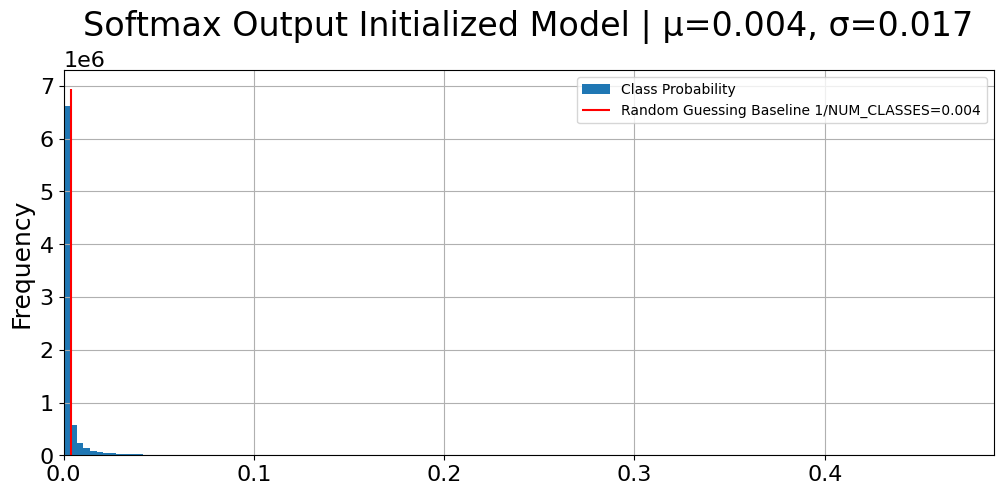

In [65]:
if TRAIN_MODEL:
    N = 32
    y_pred = model.predict(dummy_dataset, verbose=VERBOSE, steps=N).flatten()

    plt.figure(figsize=(12,5))
    plt.title(f'Softmax Output Initialized Model | µ={y_pred.mean():.3f}, σ={y_pred.std():.3f}', pad=25)
    pd.Series(y_pred).plot(kind='hist', bins=128, label='Class Probability')
    plt.xlim(0, max(y_pred) * 1.1)
    plt.vlines([1 / NUM_CLASSES], 0, plt.ylim()[1], color='red', label=f'Random Guessing Baseline 1/NUM_CLASSES={1 / NUM_CLASSES:.3f}')
    plt.grid()
    plt.legend()
    plt.show()

# Learning Rate Scheduler

In [66]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

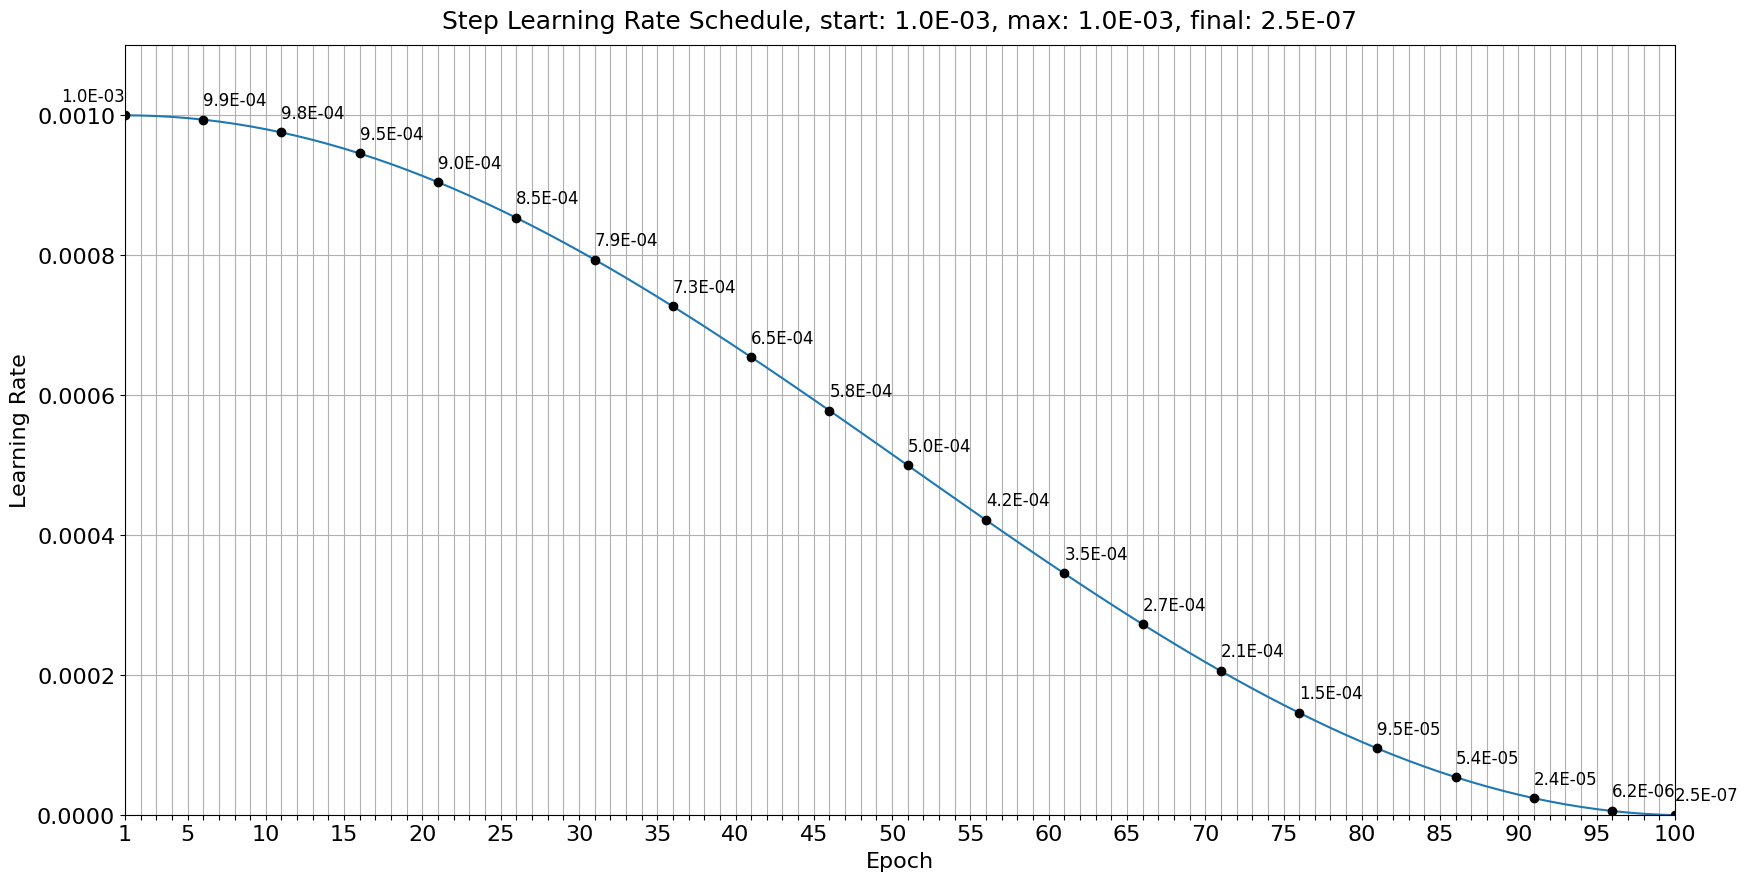

In [67]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

# Weight Decay Callback

In [68]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Performance Benchmark

In [69]:
%%timeit -n 100
if TRAIN_MODEL:
    # Verify model prediction is <<<100ms
    model.predict_on_batch({ 'frames': X[:1], 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS[:1] })
    pass

8.81 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Training

In [73]:
if USE_VAL:
    # Split data based on participant id
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)

    PARTICIPANT_IDS = pd.read_csv('train.csv')['participant_id']

    train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

    X_train = X[train_idxs]
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_train = y[train_idxs]
    y_val = y[val_idxs]
    
    # Define validation Data
    validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)

    print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')
else:
    X_train = X
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS
    y_train = y
    validation_data = None

Patient ID Intersection Train/Val: set()
X_train shape: (80229, 32, 92, 3), X_val shape: (14248, 32, 92, 3)
y_train shape: (80229,), y_val shape: (14248,)


In [74]:
if USE_VAL:
    # Verify Validation Dataset Covers All Signs
    print(f'# Unique Signs in Validation Set: {pd.Series(y_val).nunique()}')
    # Value Counts
    display(pd.Series(y_val).value_counts().to_frame('Count').iloc[[1,2,3,-3,-2,-1]])

# Unique Signs in Validation Set: 250


,Count
38,67
235,66
172,66
106,43
170,35
249,32


# Evaluate Initialzied Model

In [75]:
# Sanity Check
if TRAIN_MODEL and USE_VAL:
    _ = model.evaluate(*validation_data, verbose=2)

446/446 - 7s - loss: 7.5569 - acc: 0.0037 - top_5_acc: 0.0196 - top_10_acc: 0.0399 - 7s/epoch - 16ms/step


# Train

In [79]:
if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Get new fresh model
    model = get_model()
    
    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=({ 'frames': X_train, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TRAIN }),
            y=y_train,
            shuffle=True,
            steps_per_epoch=len(X_train) // (BATCH_SIZE),
            epochs=N_EPOCHS,
            # Only used for validation data since training data is a generator
            batch_size=BATCH_SIZE,
            validation_data=validation_data,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
            ],
            verbose = VERBOSE,
        )

(None, 32, 40, 2)
(None, 32, 40, 2)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 32, 92, 3)]  0           []                               
                                                                                                  
 tf.slice (TFOpLambda)          (None, 32, 92, 2)    0           ['frames[0][0]']                 
                                                                                                  
 tf.slice_1 (TFOpLambda)        (None, 32, 40, 2)    0           ['tf.slice[0][0]']               
                                                                                                  
 tf.slice_2 (TFOpLambda)        (None, 32, 21, 2)    0           ['tf.slice[0][0]']               
                                                          

                                                                                                  
 tf.__operators__.getitem_39 (S  (None, 32, 10)      0           ['tf.slice_4[0][0]']             
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 32, 40)      0           ['tf.slice_1[0][0]']             
 icingOpLambda)                                                                                   
                                                                                                  
 tf.math.reduce_min (TFOpLambda  ()                  0           ['tf.__operators__.getitem_2[0][0
 )                                                               ]']                              
                                                                                                  
 tf.math.r

 da)                                                             0]']                             
                                                                                                  
 tf.math.reduce_min_13 (TFOpLam  ()                  0           ['tf.__operators__.getitem_34[0][
 bda)                                                            0]']                             
                                                                                                  
 tf.__operators__.getitem_36 (S  (None, 32, 10)      0           ['tf.slice_4[0][0]']             
 licingOpLambda)                                                                                  
                                                                                                  
 tf.math.reduce_min_14 (TFOpLam  ()                  0           ['tf.__operators__.getitem_37[0][
 bda)                                                            0]']                             
          

                                                                                                  
 tf.math.subtract_13 (TFOpLambd  ()                  0           ['tf.math.reduce_max_6[0][0]',   
 a)                                                               'tf.math.reduce_min_13[0][0]']  
                                                                                                  
 tf.__operators__.getitem_35 (S  (None, 32, 10)      0           ['tf.slice_4[0][0]']             
 licingOpLambda)                                                                                  
                                                                                                  
 tf.math.subtract_14 (TFOpLambd  (None, 32, 10)      0           ['tf.__operators__.getitem_36[0][
 a)                                                              0]',                             
                                                                  'tf.math.reduce_min_14[0][0]']  
          

 tf.where_7 (TFOpLambda)        (None, 32, 10)       0           ['tf.math.equal_7[0][0]',        
                                                                  'tf.compat.v1.div_7[0][0]']     
                                                                                                  
 tf.expand_dims_1 (TFOpLambda)  (None, 32, 40, 1)    0           ['tf.where[0][0]']               
                                                                                                  
 tf.expand_dims_2 (TFOpLambda)  (None, 32, 40, 1)    0           ['tf.where_1[0][0]']             
                                                                                                  
 tf.expand_dims_3 (TFOpLambda)  (None, 32, 21, 1)    0           ['tf.where_2[0][0]']             
                                                                                                  
 tf.expand_dims_4 (TFOpLambda)  (None, 32, 21, 1)    0           ['tf.where_3[0][0]']             
          


Epoch 3: LearningRateScheduler setting learning rate to 0.0009990133642141358.
learning rate: 9.99e-04, weight decay: 5.00e-05
Epoch 3/100
313/313 [==============================] - 18s 56ms/step - loss: 4.4404 - acc: 0.0820 - top_5_acc: 0.2502 - top_10_acc: 0.3724 - val_loss: 3.9403 - val_acc: 0.1221 - val_top_5_acc: 0.3422 - val_top_10_acc: 0.4882 - lr: 9.9901e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00099778098230154.
learning rate: 9.98e-04, weight decay: 4.99e-05
Epoch 4/100
313/313 [==============================] - 18s 56ms/step - loss: 4.0379 - acc: 0.1304 - top_5_acc: 0.3527 - top_10_acc: 0.4866 - val_loss: 3.7479 - val_acc: 0.1520 - val_top_5_acc: 0.3972 - val_top_10_acc: 0.5476 - lr: 9.9778e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000996057350657239.
learning rate: 9.96e-04, weight decay: 4.98e-05
Epoch 5/100
313/313 [==============================] - 18s 57ms/step - loss: 3.8979 - acc: 0.1505 - top_5_acc: 0.3860 - top_10_acc: 0.5

learning rate: 8.64e-04, weight decay: 4.32e-05
Epoch 25/100
313/313 [==============================] - 17s 55ms/step - loss: 1.7481 - acc: 0.5543 - top_5_acc: 0.8108 - top_10_acc: 0.8790 - val_loss: 1.8974 - val_acc: 0.5191 - val_top_5_acc: 0.8004 - val_top_10_acc: 0.8785 - lr: 8.6448e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0008535533905932737.
learning rate: 8.54e-04, weight decay: 4.27e-05
Epoch 26/100
313/313 [==============================] - 17s 55ms/step - loss: 1.6581 - acc: 0.5745 - top_5_acc: 0.8261 - top_10_acc: 0.8890 - val_loss: 2.0029 - val_acc: 0.5019 - val_top_5_acc: 0.7821 - val_top_10_acc: 0.8660 - lr: 8.5355e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0008422735529643444.
learning rate: 8.42e-04, weight decay: 4.21e-05
Epoch 27/100
313/313 [==============================] - 17s 55ms/step - loss: 1.6472 - acc: 0.5755 - top_5_acc: 0.8266 - top_10_acc: 0.8896 - val_loss: 1.9087 - val_acc: 0.5150 - val_top_5_acc: 0.7981 - val_t

313/313 [==============================] - 17s 55ms/step - loss: 0.9073 - acc: 0.7485 - top_5_acc: 0.9237 - top_10_acc: 0.9546 - val_loss: 1.9765 - val_acc: 0.5354 - val_top_5_acc: 0.8005 - val_top_10_acc: 0.8740 - lr: 5.6267e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.0005470541566592572.
learning rate: 5.47e-04, weight decay: 2.74e-05
Epoch 48/100
313/313 [==============================] - 17s 55ms/step - loss: 0.8471 - acc: 0.7659 - top_5_acc: 0.9307 - top_10_acc: 0.9574 - val_loss: 1.8593 - val_acc: 0.5665 - val_top_5_acc: 0.8169 - val_top_10_acc: 0.8858 - lr: 5.4705e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.0005313952597646568.
learning rate: 5.31e-04, weight decay: 2.66e-05
Epoch 49/100
313/313 [==============================] - 17s 55ms/step - loss: 0.8373 - acc: 0.7681 - top_5_acc: 0.9310 - top_10_acc: 0.9581 - val_loss: 1.9342 - val_acc: 0.5517 - val_top_5_acc: 0.8120 - val_top_10_acc: 0.8812 - lr: 5.3140e-04

Epoch 50: LearningRateSch

313/313 [==============================] - 18s 56ms/step - loss: 0.1741 - acc: 0.9567 - top_5_acc: 0.9876 - top_10_acc: 0.9927 - val_loss: 2.4359 - val_acc: 0.5652 - val_top_5_acc: 0.8090 - val_top_10_acc: 0.8777 - lr: 2.4472e-05

Epoch 92: LearningRateScheduler setting learning rate to 1.985315716152847e-05.
learning rate: 1.99e-05, weight decay: 9.93e-07
Epoch 92/100
313/313 [==============================] - 18s 56ms/step - loss: 0.1753 - acc: 0.9562 - top_5_acc: 0.9880 - top_10_acc: 0.9930 - val_loss: 2.4838 - val_acc: 0.5597 - val_top_5_acc: 0.8033 - val_top_10_acc: 0.8719 - lr: 1.9853e-05

Epoch 93: LearningRateScheduler setting learning rate to 1.5708419435684463e-05.
learning rate: 1.57e-05, weight decay: 7.85e-07
Epoch 93/100
313/313 [==============================] - 18s 56ms/step - loss: 0.1687 - acc: 0.9589 - top_5_acc: 0.9881 - top_10_acc: 0.9928 - val_loss: 2.4730 - val_acc: 0.5620 - val_top_5_acc: 0.8043 - val_top_10_acc: 0.8736 - lr: 1.5708e-05

Epoch 94: LearningRateSc

In [80]:
# Save Model Weights
model.save_weights('models/transformer_base.h5')

In [137]:
if USE_VAL:
    # Validation Predictions
    y_val_pred = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
    # Label
    labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

446/446 - 6s - 6s/epoch - 13ms/step


# Landmark Attention Weights

In [138]:
# Landmark Weights
weights = scipy.special.softmax(model.get_layer('embedding').weights[15])
landmarks = ['lips_embedding', 'left_hand_embedding', 'right_hand_embedding', 'pose_embedding']

# Learned attention weights, initialized at uniform 25%
for w, lm in zip(weights, landmarks):
    print(f'{lm} weight: {(w*100):.1f}%')

lips_embedding weight: 22.0%
left_hand_embedding weight: 28.6%
right_hand_embedding weight: 30.9%
pose_embedding weight: 18.5%


# Classification Report

In [139]:
def print_classification_report():
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_val,
            y_val_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Add signs
    classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
    classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(NUM_CLASSES).sort_values('f1-score', ascending=False),
        classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)

In [140]:
if USE_VAL:
    print_classification_report()

,precision,recall,f1-score,support,sign,sign_ord
horse,0.98,0.98,0.98,60,horse,119
gum,0.98,0.95,0.97,59,gum,103
drink,0.95,0.96,0.96,57,drink,63
frog,0.93,0.96,0.95,54,frog,90
flower,0.96,0.93,0.95,57,flower,86
doll,0.92,0.95,0.94,61,doll,59
shirt,0.96,0.91,0.93,54,shirt,195
airplane,0.93,0.93,0.93,57,airplane,2
for,0.96,0.89,0.93,57,for,88
dad,0.96,0.89,0.93,57,dad,55


# Training History

In [141]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

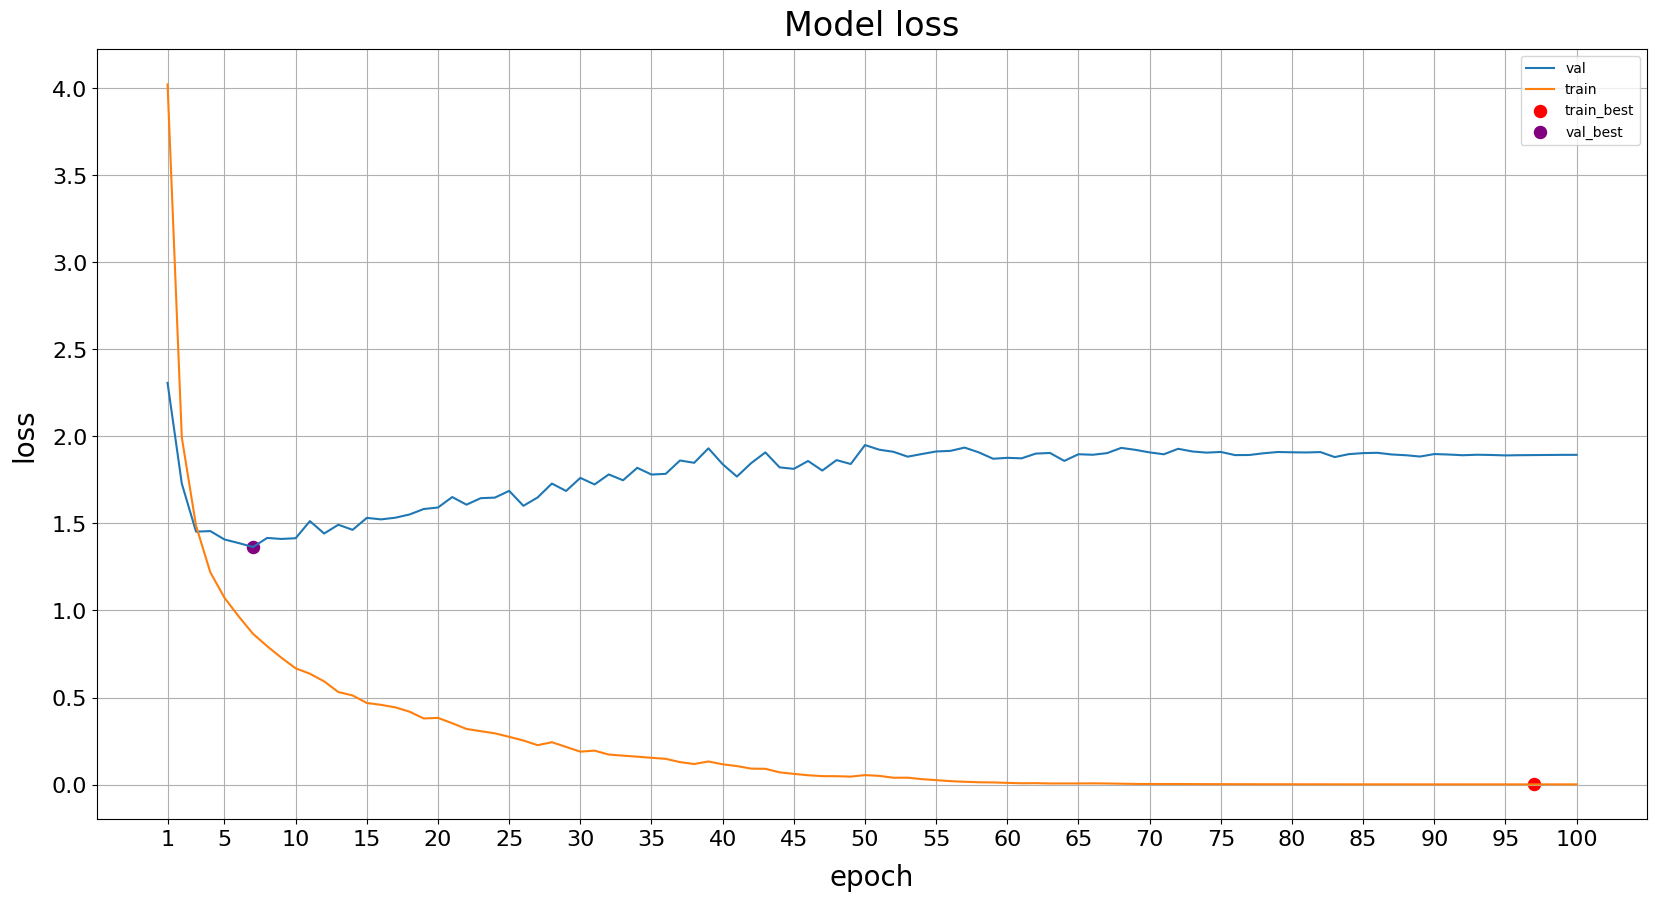

In [142]:
if TRAIN_MODEL:
    plot_history_metric('loss', f_best=np.argmin)

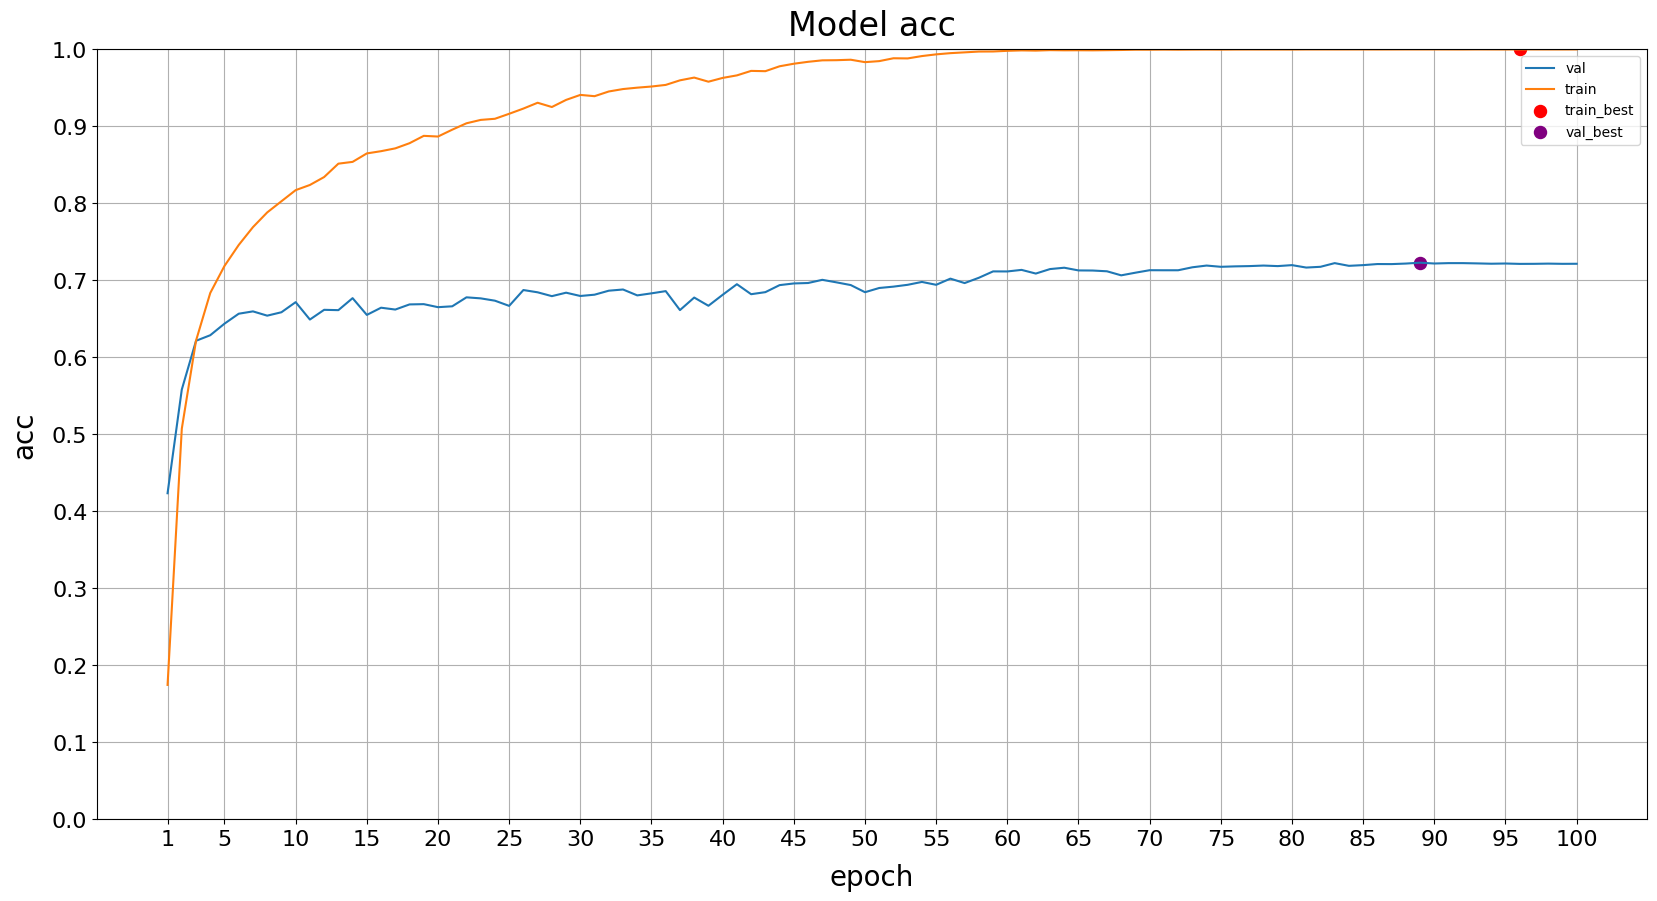

In [143]:
if TRAIN_MODEL:
    plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

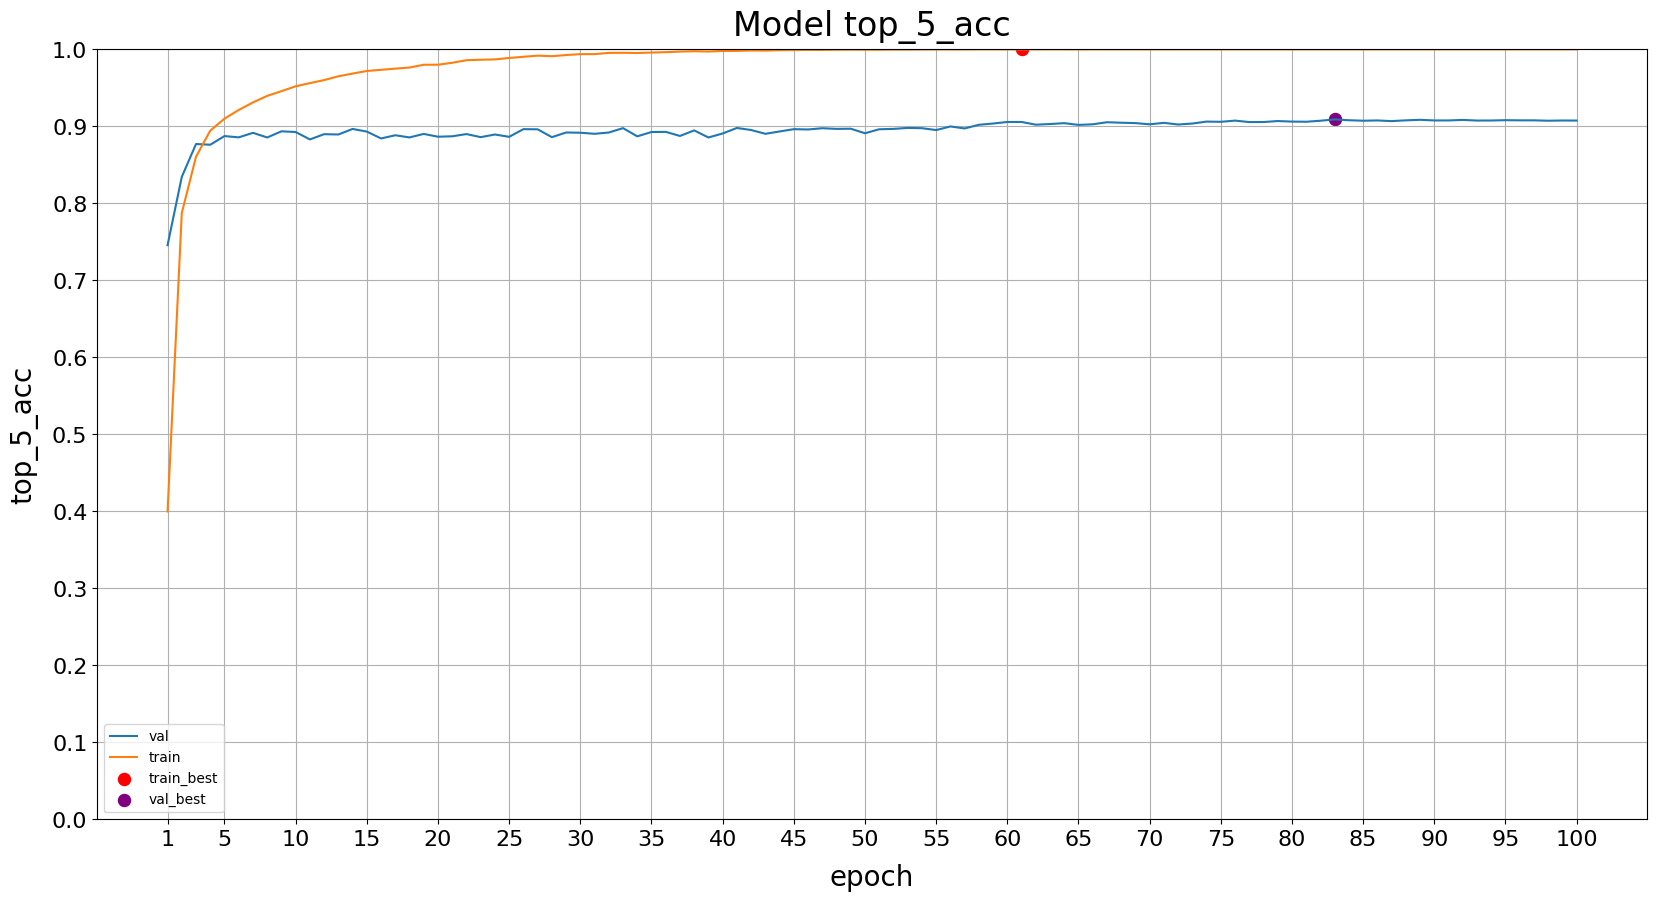

In [144]:
if TRAIN_MODEL:
    plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

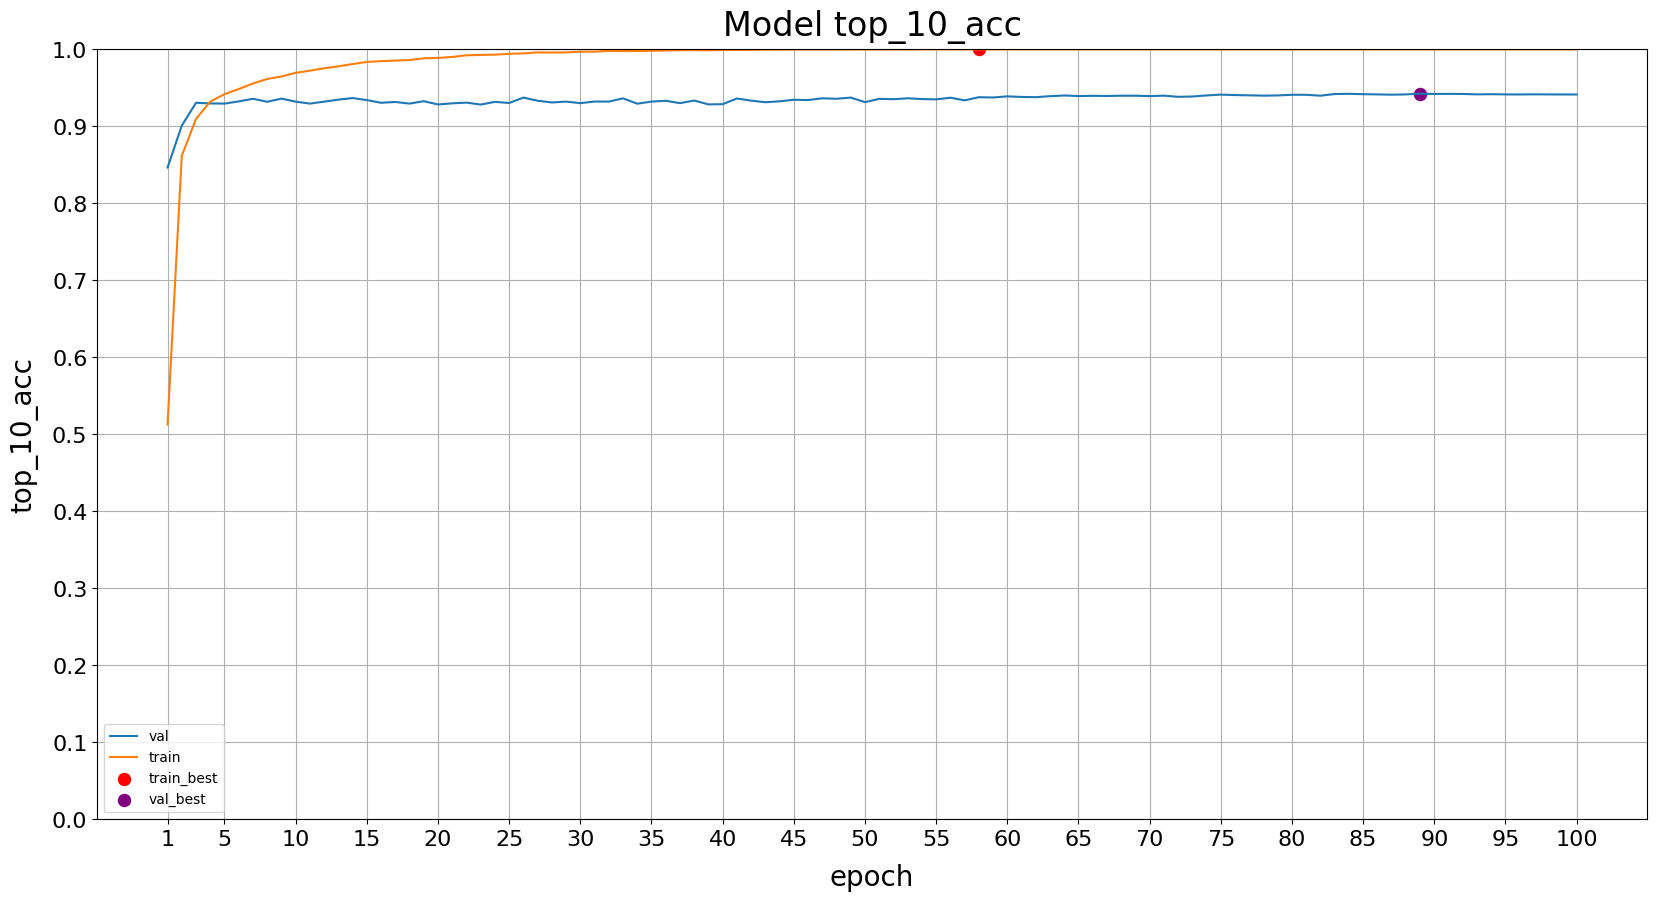

In [145]:
if TRAIN_MODEL:
    plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Submission

Submission code loosley based on [this notebook](https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline#baseline) by [Darien Schettler
](https://www.kaggle.com/dschettler8845)

In [146]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_ROWS, N_DIMS], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Preprocess Data
        x, non_empty_frame_idxs = self.preprocess_layer(inputs)
        # Add Batch Dimension
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
        # Make Prediction
        outputs = self.model({ 'frames': x, 'non_empty_frame_idxs': non_empty_frame_idxs })
        # Squeeze Output 1x250 -> 250
        outputs = tf.squeeze(outputs, axis=0)

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# Sanity Check
demo_raw_data = load_relevant_data_subset(train['file_path'].values[5])
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)["outputs"]
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
demo_prediction = demo_output.numpy().argmax()
print(f'demo_prediction: {demo_prediction}, correct: {train.iloc[0]["sign_ord"]}')

demo_raw_data shape: (30, 543, 3), dtype: float32
demo_output shape: (250,), dtype: <dtype: 'float32'>
demo_prediction: 67, correct: 25


In [147]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Zip Model
!zip submission.zip /kaggle/working/model.tflite

INFO:tensorflow:Assets written to: /tmp/tmppataliwp/assets


INFO:tensorflow:Assets written to: /tmp/tmppataliwp/assets


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/model.tflite'

In [ ]:
# Verify TFLite model can be loaded and used for prediction
!pip install tflite-runtime
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("/kaggle/working/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=demo_raw_data)
sign = output['outputs'].argmax()

print("PRED : ", ORD2SIGN.get(sign), f'[{sign}]')
print("TRUE : ", train.sign.values[0], f'[{train.sign_ord.values[0]}]')